In [1]:
from torch.utils.data import DataLoader
from attrbench.lib import PixelMaskingPolicy
from experiments.lib.util import get_ds_model, get_methods, get_n_pixels
from experiments.lib import attribution
import torch
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
ds_name = "ImageNette"
model_name = "resnet18"
device = "cuda"
pmp = PixelMaskingPolicy(0.)
dataset, model = get_ds_model(ds_name, model_name)
model.to(device)
model.eval()
dl = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
rand = attribution.PixelAggregation(attribution.Random(), "avg")

In [3]:
samples = None
it = iter(dl)
samples, labels = next(it)
samples = samples.to(device)
labels = labels.to(device)
out = model(samples)
correctly_classified = (torch.argmax(out, dim=1) == labels)
samples = samples[correctly_classified]
labels = labels[correctly_classified]
print(samples.size(0))

32


In [4]:
n_pixels = 100
n_perturbations = 1000
diffs = []
for i in trange(n_perturbations):
    # Random attributions
    attrs = rand(samples, labels)
    attrs = attrs.flatten(1)
    # Mask top n pixels
    sorted_indices = attrs.argsort().cpu().detach().numpy()
    masked_samples = pmp(samples, sorted_indices[:, -n_pixels:])
    # Record output difference
    with torch.no_grad():
        out = model(masked_samples).gather(dim=1, index=labels.unsqueeze(-1)).cpu().detach()
    diffs.append(out.flatten())
diffs = np.stack(diffs)

100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]


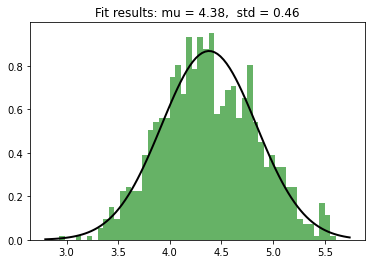

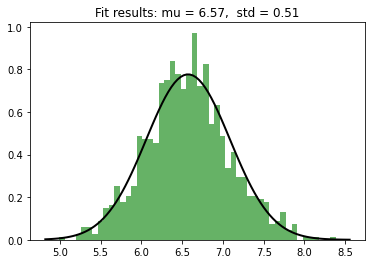

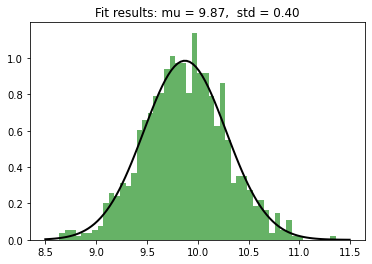

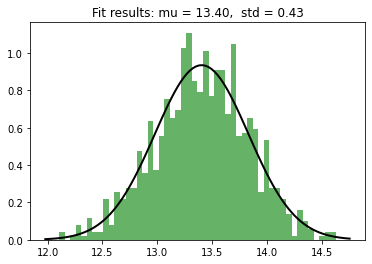

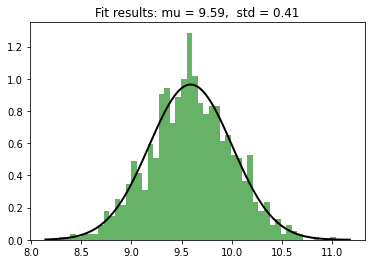

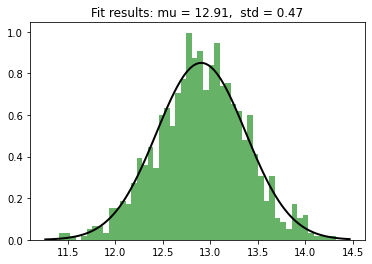

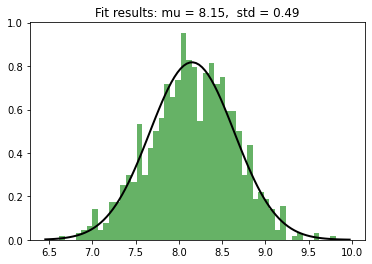

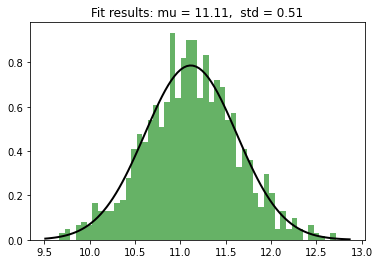

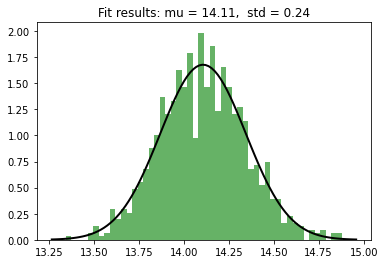

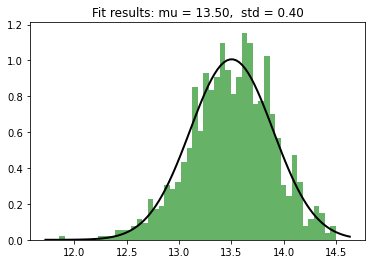

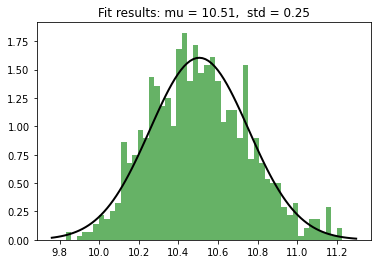

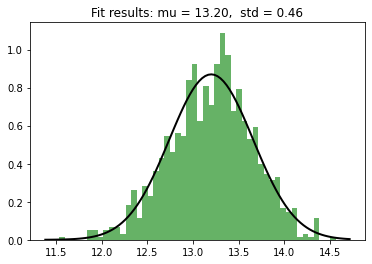

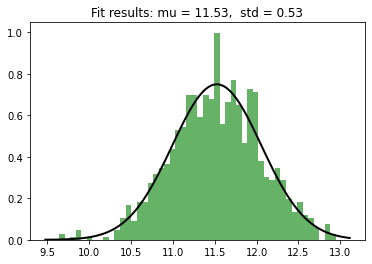

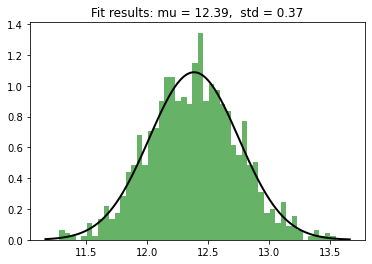

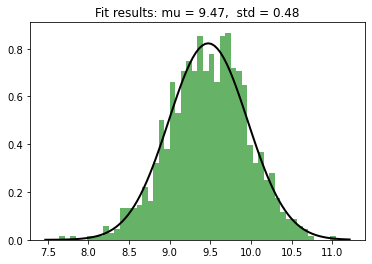

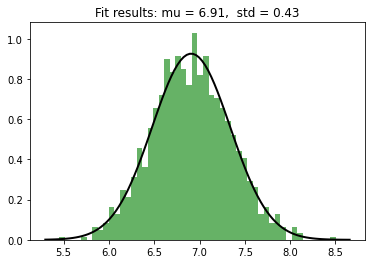

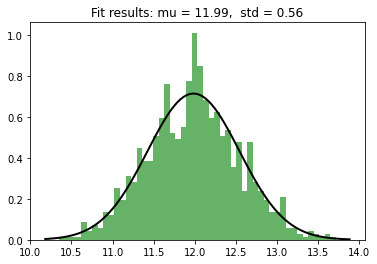

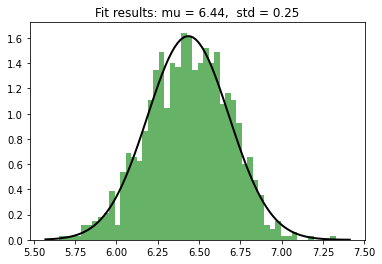

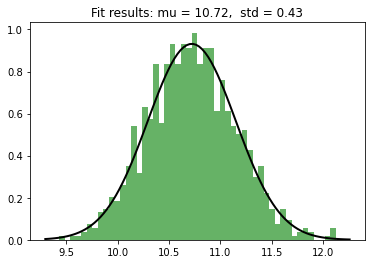

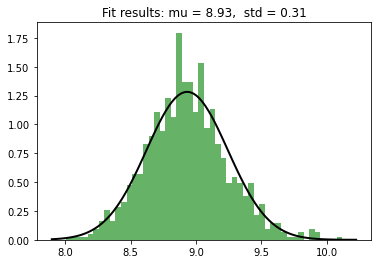

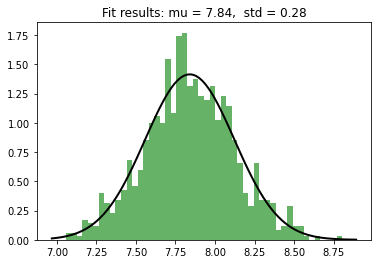

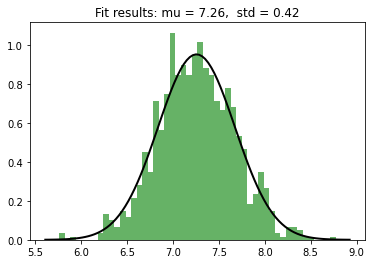

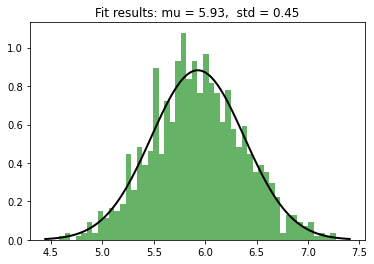

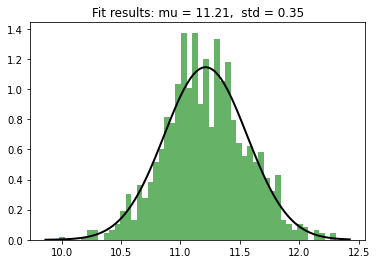

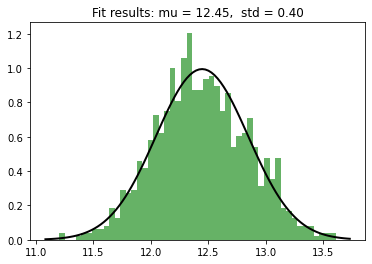

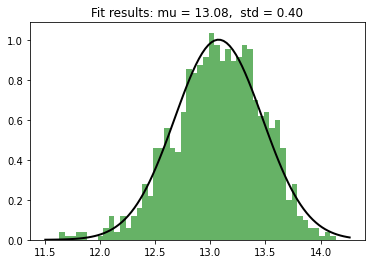

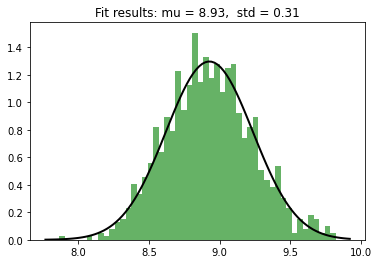

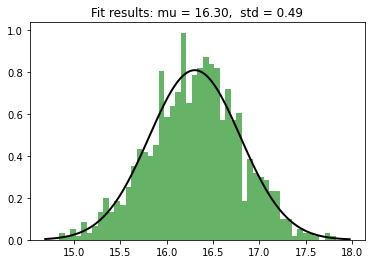

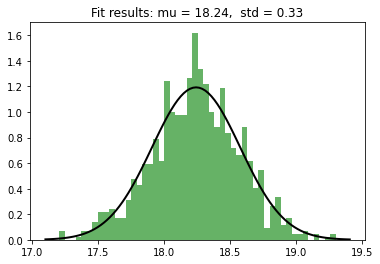

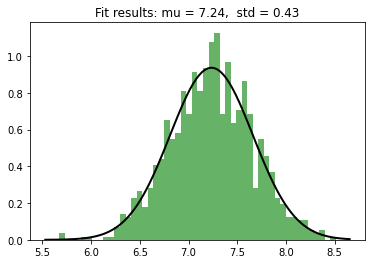

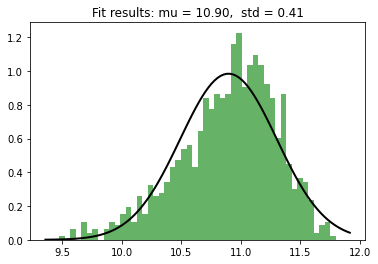

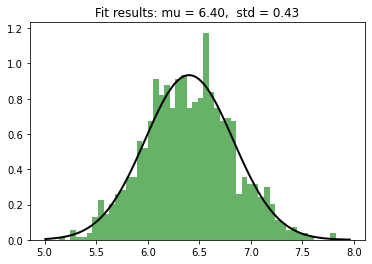

In [5]:
for i in range(diffs.shape[1]):
    data = diffs[:, i].flatten()
    # Plot the histogram
    plt.hist(data, bins=50, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()

In [6]:
diffs.shape

(1000, 32)